# Example using audio from Fender dataset: 
In this notebook all model paremeters, i.e:  noise variance, lengthscale and variance of activation, all frequencies, variances and lenghscale of component, and variational distributions are learned simultaneously by maximazing the marginal likelihood.

In [1]:
%matplotlib inline
import sys 
sys.path.append('../../../../')
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import gpflow, gpitch
reload(gpitch)
from gpitch.amtgp import logistic
from scipy.fftpack import fft, ifft, ifftshift
from scipy import signal
import time
from gpitch import myplots
import soundfile


plt.rcParams['figure.figsize'] = (16, 5)  # set plot size

## Import data

Load and plot data.

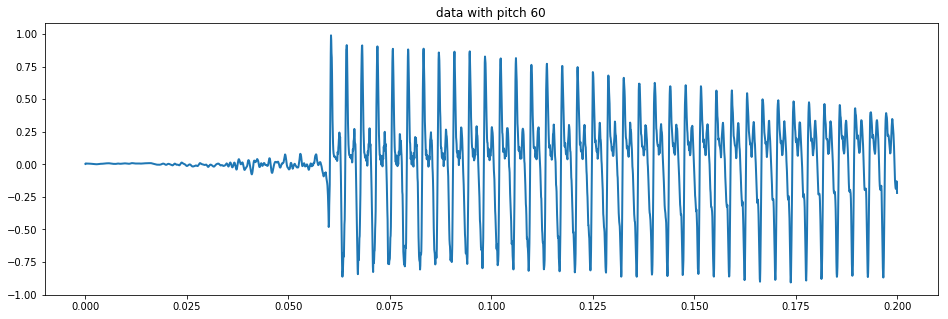

In [2]:
midi = '60'
filename = '../../../../../datasets/fender/train/m_' + str(midi) + '.wav'
N = 3200 # number of data points to load
y, fs = soundfile.read(filename, frames=N)
y = y.reshape(-1,1)
x = np.linspace(0, (N-1.)/fs, N).reshape(-1, 1)
plt.figure()
plt.title('data with pitch ' + midi)
plt.plot(x, y, lw=2)

## Define model
We take advantage of the information available in the Fourier transform of the data to initialize the component hyper-parameters, i.e. the frequency of each harmonic and its variance.

In [3]:
Nc = 10
ideal_f0 = gpitch.amtgp.midi2frec(int(midi))
F_star, S_star, F, Y, S = gpitch.amtgp.init_com_params(y=y, fs=fs, Nh=Nc, ideal_f0=ideal_f0, scaled=True)  # get freqs and var 

(0, 8000)

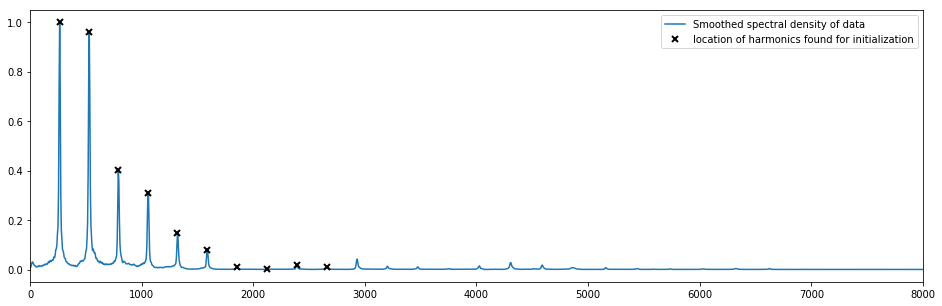

In [4]:
plt.figure()
plt.plot(F, S/np.max(S))
plt.plot(F_star, S_star/np.max(S_star), 'xk', mew=2)
plt.legend(['Smoothed spectral density of data', 'location of harmonics found for initialization'])
plt.xlim([0, 8000])

Define kernels for component and activation, and generate model object ("sigmoid model")

In [5]:
kern_com = gpitch.kernels.MaternSpecMix(input_dim=1, lengthscales=0.1, variances=S_star, 
                                        frequencies=F_star, Nc=Nc)
kern_act = gpflow.kernels.Matern32(input_dim=1, lengthscales=1., variance=10.)

In [6]:
dec = 120  # samples per window, decimation factor
z = np.vstack((x[::dec].copy(), x[-1].copy()))
m = gpitch.modgp.ModGP(x=x, y=y, z=z, kern_com=kern_com, kern_act=kern_act, whiten=True)

Set all parameters free to optimize, but variances of component

In [7]:
m.kern_com.fixed = True
m.kern_com.lengthscales.fixed = False
m.kern_com.lengthscales.transform = gpflow.transforms.Logistic(0., 1.0)
m.fixed_msmkern_params(freq=False, var=True)
m.kern_act.fixed = False
m.likelihood.variance.fixed = False
m.z.fixed = True

In [8]:
m

Name,values,prior,constraint
model.kern_act.lengthscales,[ 1.],None,+ve
model.kern_act.variance,[ 10.],None,+ve
model.kern_com.frequency_1,[ 265.16572858],None,+ve
model.kern_com.frequency_10,[ 2656.66041276],None,+ve
model.kern_com.frequency_2,[ 530.33145716],None,+ve
model.kern_com.frequency_3,[ 790.49405879],None,+ve
model.kern_com.frequency_4,[ 1055.65978737],None,+ve
model.kern_com.frequency_5,[ 1320.82551595],None,+ve
model.kern_com.frequency_6,[ 1585.99124453],None,+ve
model.kern_com.frequency_7,[ 1851.15697311],None,+ve


## Inference

In [9]:
st = time.time()
logt = []
logx = []
logf = []
def logger(x):
    if (logger.i % 10) == 0:
        logx.append(x)
        logf.append(m._objective(x)[0])
        logt.append(time.time() - st)
    logger.i+=1
logger.i = 1
m.x.minibatch_size = 100
m.y.minibatch_size = 100

In [10]:
maxiter = 1000
m.optimize(method=tf.train.AdamOptimizer(learning_rate=0.01), maxiter=maxiter, 
           callback=logger)

     fun: -4228.1075614000811
     jac: array([ -3.52851396e+01,  -4.87809674e+00,   8.07198751e-01, ...,
         4.66152840e-04,   3.52231953e-04,  -1.73638986e-03])
 message: 'Finished iterations.'
  status: 'Finished iterations.'
 success: True
       x: array([ -2.18165894e+00,   1.35194561e+01,   2.62763882e+02, ...,
         1.02405438e-02,  -6.00952468e-02,   1.44367204e-01])

List of learned hyperparameters

Text(0,0.5,u'ELBO')

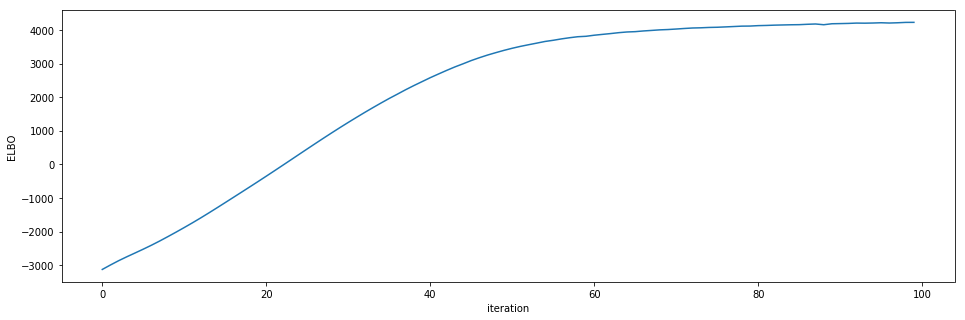

In [11]:
plt.plot(-np.array(logf))
plt.xlabel('iteration')
plt.ylabel('ELBO')

In [12]:
mean_f, var_f, mean_g, var_g, x_plot  = m.predict_all(x)

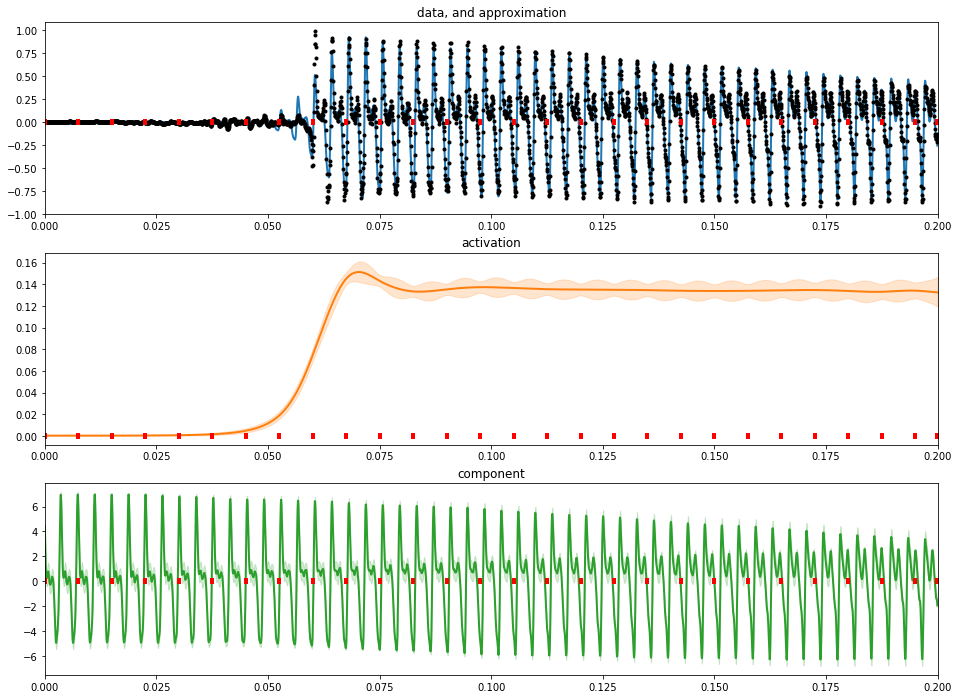

In [13]:
xlim = [0.0, 0.2]
myplots.plot_results(mean_f, var_f, mean_g, var_g, x_plot, y, z, xlim)

In [14]:
print('The ideal natural frequency is ' + str(ideal_f0) + 'Hz')

The ideal natural frequency is 261.625565301Hz


In [15]:
m
#print ideal_f0

Name,values,prior,constraint
model.kern_act.lengthscales,[ 0.10692903],None,+ve
model.kern_act.variance,[ 13.5194584],None,+ve
model.kern_com.frequency_1,[ 262.76388284],None,+ve
model.kern_com.frequency_10,[ 2663.31683072],None,+ve
model.kern_com.frequency_2,[ 526.60401222],None,+ve
model.kern_com.frequency_3,[ 789.42486189],None,+ve
model.kern_com.frequency_4,[ 1054.59132075],None,+ve
model.kern_com.frequency_5,[ 1318.08807387],None,+ve
model.kern_com.frequency_6,[ 1581.39148154],None,+ve
model.kern_com.frequency_7,[ 1847.43571247],None,+ve


### Plot learned kernel

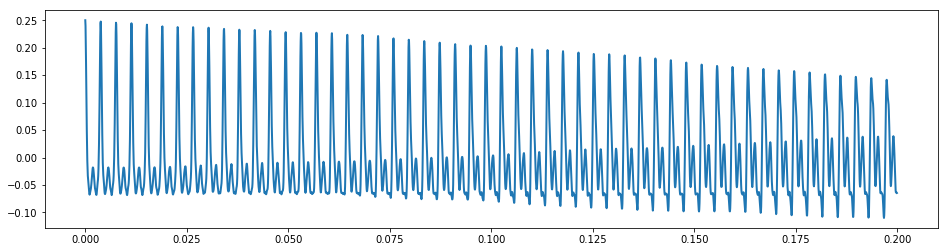

In [16]:
k_plot_model = m.kern_com.compute_K(x, np.asarray(0.).reshape(-1,1))
plt.figure(figsize=(16, 4))
plt.plot(x, k_plot_model, lw=2)

### Compare spectral density of data and learned component kernel

(0, 8000)

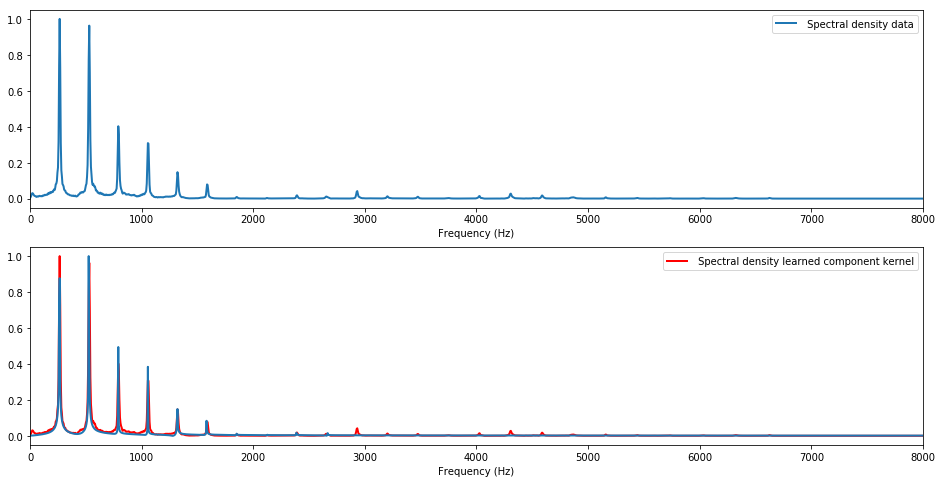

In [17]:
N = x.size
Yk1 = fft(k_plot_model.reshape(-1,)) #  FFT data
Sk1 =  2./N * np.abs(Yk1[0:N//2]) #  spectral density data

plt.figure(figsize=(16, 8))
plt.subplot(2, 1, 1)
plt.plot(F, S / np.max(np.abs(S)), lw=2)
plt.legend([' Spectral density data'])
plt.xlabel('Frequency (Hz)')
plt.xlim([0, 8000])

plt.subplot(2, 1, 2)
plt.plot(F, S / np.max(np.abs(S)), 'r', lw=2)
plt.plot(F, Sk1 / np.max(np.abs(Sk1)), lw=2)
plt.legend([' Spectral density learned component kernel'])
plt.xlabel('Frequency (Hz)')
plt.xlim([0, 8000])

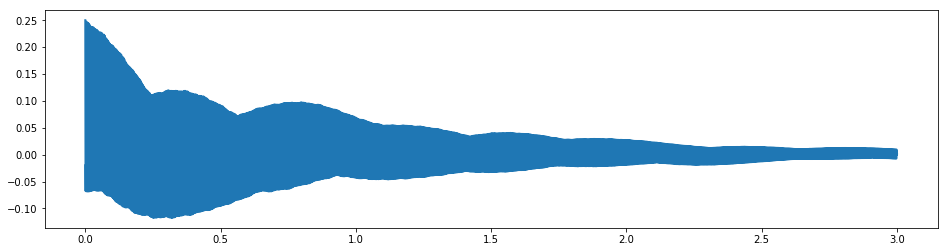

In [18]:
xkernel = np.linspace(0,3, 48000).reshape(-1, 1)
k_plot_model = m.kern_com.compute_K(xkernel, np.asarray(0.).reshape(-1,1))

plt.figure(figsize=(16, 4))
plt.plot(xkernel, k_plot_model, lw=2)

In [19]:
tf.reset_default_graph()